# SceneGen

## Utils and Helper Functions

In [1]:
import os
import pickle
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as ss
import numpy as np
from colour import Color

from SemanticObject import *

### Config

In [2]:
##Training:
load_data = True #If load_data is true, it will unpickle pre-parsed Semantic Objects. 
                    #Otherwise, it will load and parse rooms from `data/`

objects_to_model = ['bed', 'chair', 'storage', 'decor', 'picture', 'table', 'sofa', 'tv']
symmetry = {'decor':0, 'table': '0',
           'storage': 1, 'picture': 1,
            'bed':2, 'chair':2, 'sofa':2, 'tv':2}
#symmetric 0, inside facing 1, #asymmetric 2

#orientation features to use:
#object to room relationships
use_center = True
use_similarity = False
use_room_position_orien = True
#object to group relationships
facing_objects = objects_to_model 
next_to_objects = [] 

#position features to use
#object to room relationship
use_room_position = True
#object to group relationships
avg_dist_objects = objects_to_model 
surrounding_objects = objects_to_model

##Sampling
#sampling resolution
pointsnumber = 50 
anglesnumber = 8
#allowable Overlaps:
can_overlap = {'bed':['other', 'decor', 'picture'],
                'chair':['other', 'decor', 'picture', 'table', 'storage'],
                'storage':['other',  'storage', 'decor', 'picture', 'table', 'tv'],
                'decor':['other', 'bed', 'chair', 'storage', 'decor', 'picture', 'table', 'tv', 'sofa'],
                'picture':['other', 'bed', 'chair', 'storage', 'decor', 'picture', 'table', 'tv', 'sofa'],
                 'table':['other', 'chair', 'decor', 'picture'],
                  'tv':['other', 'storage', 'decor', 'picture', 'table'],
                   'sofa':['other', 'decor', 'picture'],
                   'other':['other', 'bed', 'chair', 'storage', 'decor', 'picture', 'table', 'tv', 'sofa']}
#use 'floor' object to calculate room info
use_floor = False


In [3]:
"""
Take an input line and return a SemanticObject
"""
def createSemanticObject(input):
    vals = input.split(',')
    label = vals[0]
    px, py, pz, a0x, a0y, a0z, a1x, a1y, a1z, r0, r1, r2,sym = list(map(float, vals[1:]))
    axis1 = [a0x, a0y, a0z]
    axis2 = [a1x, a1y, a1z]
    radius = [r0, r1, r2]
    center = [px, py, pz]
    obj = SemanticObject(label, center, radius, axis1, axis2, sym)
    return obj

In [4]:
"""
Parse a single rooms, creating semantic objects and establishing room and object relationships.
Returns a list of SemanticObjects
"""
def parseRoom(fname, input_dir, add_objects = False):
    inputHandler = open(input_dir+fname, "r")
    listOfLines = inputHandler.readlines()
    inputHandler.close()
    if use_floor:
        objects = [createSemanticObject(l) for l in listOfLines[1:] if l[0] != '*' and l[0] != 'floor']
    else:
        objects = [createSemanticObject(l) for l in listOfLines[1:] if l[0] != '*']
        
    if (len(objects) < 1):
        return []
    
    if use_floor:
        floor = [createSemanticObject(l) for l in listOfLines[1:] if l[0] != '*' and l[0] == 'floor']        
        room_info = getRoomInfo(floor)
    else:
        room_info = getRoomInfo(objects)
        
    if add_objects:
        objects_to_add = [l for l in listOfLines[1:] if l[0] == '*']
    for obj in objects:
        obj.updateRoomPosition(room_info)
    for first_obj, second_obj in itertools.permutations(objects, 2):
        first_obj.update_relationship(second_obj)
    for obj in objects:
        obj.updateProximities(room_info)
    if add_objects:
        return objects, objects_to_add
    else:
        return objects

In [5]:
"""
2D projection of objects in a room
"""
def drawRect(item, color):
    currentAxis=plt.gca()
    center_1 = np.array(item.center[:2])
    axis1 = np.array(item.axis1[:2]) * item.radius[0]
    axis2 = np.array(item.axis2[:2]) * item.radius[1]

    mm1 = (center_1 - axis1 - axis2)
    pm1 = (center_1 + axis1 - axis2)
    mp1 = (center_1 - axis1 + axis2)
    pp1 = (center_1 + axis1 + axis2)
    corners_first = [mm1, pm1, pp1, mp1]
    orig = mathutils.Vector(item.center[:2])
    axis = np.array(item.axis1[:2])
    if color == 'k':
        plt.arrow(orig[0],orig[1], axis[0], axis[1] , color = 'k')
        style =  '--'
    elif color == 'm':
        style =  '--'
    else:
        style =  '-.'
        plt.arrow(orig[0],orig[1], axis[0]/2, axis[1]/2 , color = 'c')
        style =  '-'

    rect = patches.Polygon(corners_first, linewidth=2,edgecolor=color,facecolor='none', ls = style)
    currentAxis.add_patch(rect)

def visualizeScene(objects, addedObj = None, room_info = None):
    if room_info:
        min_x, max_x, min_y, max_y, _ = room_info
    else:
        min_x, max_x, min_y, max_y, _ = getRoomInfo(objects)
    currentAxis=plt.gca()

    rect = patches.Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]], linewidth=2,edgecolor='r',facecolor='none', ls = '-.')
    currentAxis.add_patch(rect)

    for item in objects:
        drawRect(item, 'c')
        plt.scatter(item.center[0],item.center[1], label = item.label)
        plt.annotate(item.label, (item.center[0],item.center[1]))

    if addedObj:
        drawRect(addedObj, 'm')
        plt.scatter(addedObj.center[0],addedObj.center[1], label = "NEW" + addedObj.label)
        plt.annotate("NEW" +addedObj.label, (addedObj.center[0],addedObj.center[1]))


## Training

We train SceneGen from a dataset where scenes are in txt files with a heading `label,px,py,pz,a0x,a0y,a0z,a1x,a1y,a1z,r0,r1,r2,sym` and each object is on separate lines in a folder `data/`. 

We have two main steps in our training phase

1) Each scene is parsed, and relationships (Spatial Scene Graph is extracted), Scene Graphs are aggregated into our knowledge model

2) Using this, we approximate models using KDE for each objects position and orientations for asymmetric objects 



In [6]:
"""
Parse all rooms and return a list of all semantic objects in those files 
If you specify a test split, those files will not be parsed
"""
def parseAllRooms(input_dir, test_fnames = []):
    print("Parsing Rooms")
    fnames = os.listdir(input_dir)
    fnames =[f for f in fnames if f not in test_fnames]
    all_objects = []
    filenum = 0
    obj_count = 0
    for filename in fnames:
        filenum += 1
        if filename.endswith(".txt"):
            objects = parseRoom(filename, input_dir)
            all_objects.extend(objects)
            obj_count += len(objects)
    print("Done Parsing Rooms", filenum, obj_count)
    
    with open("semantic_objects.pkl", "wb") as f:
        pickle.dump(len(all_objects), f)
        for value in all_objects:
            pickle.dump(value, f)
        
    return all_objects

In [10]:
"""
We provide Semantic Objects in a pickled format that can be used. 
If load_data is true, it will unpickle that. Otherwise, it will load data from `input`

"""
if load_data:
    all_objects = []
    with open("semantic_objects.pkl", "rb") as f:
        for _ in range(pickle.load(f)):
            all_objects.append(pickle.load(f))
    print(len(all_objects))
else:
    all_objects = parseAllRooms(input_dir = 'data/')

14649


In [11]:
"""
Builds orientation prediction model for a type of object
"""
def buildOrientationModel(all_objects, label_to_model):
    items = [obj for obj in all_objects if obj.label == label_to_model]
    count = len(items)
    model_dim = (len(facing_objects) + len(next_to_objects) + sum([use_center, int(use_similarity) * 2 + use_room_position]))
    if count <= model_dim:
        print(label_to_model, "seen only", len(items), "Model Dimension", model_dim)
        return None 
    dep_data_points = []
    var_string = 'o' * model_dim
    for item in items:
        y = item.getOrientationFeatures(facing_objects, next_to_objects, use_center, use_similarity, use_room_position_orien)
        dep_data_points.append(y)
    models = []
    model = sm.nonparametric.KDEMultivariate(data = dep_data_points, var_type = var_string)
    heading = (facing_objects, next_to_objects, use_center, use_similarity, use_room_position)
    return model, heading



In [12]:
"""
Builds position prediction model for a type of object
"""
def buildPositionModel(all_objects, label_to_model):
    items = [obj for obj in all_objects if obj.label == label_to_model]
    count = len(items)    
    model_dim = (len(avg_dist_objects) + len(surrounding_objects) + use_room_position)
    if count <= model_dim:
        print(label_to_model, "seen only", len(items), "Model Dimension", model_dim)
        return None
    dep_data_points = []
    var_string = 'o' * (len(avg_dist_objects) + len(surrounding_objects) + 1)
    for item in items:
        y = item.getPositionFeatures(avg_dist_objects, surrounding_objects, use_room_position)
        dep_data_points.append(y)
    bw_str = [0.01] * len(var_string) #use small bandwidth to reduce effect of max values in avg dist
    model = sm.nonparametric.KDEMultivariate(data = dep_data_points, var_type = var_string, bw=bw_str)
    heading = [avg_dist_objects, surrounding_objects, use_room_position]
    return model, heading

In [13]:
"""
Export position models for all objects and orientation models for asymmetric objects 
"""
def exportModels(output_dir):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    for label in objects_to_model:
        position_model, position_heading= buildPositionModel(all_objects, label)
        if symmetry[label] == 2:
            orientation_model, orientation_heading = buildOrientationModel(all_objects, label)
        else:
            orientation_model, orientation_heading = None, None
        models = (position_model, position_heading, orientation_model, orientation_heading)
        output_file = output_dir + label + '.pkl'
        pd.to_pickle(models, output_file)
        print("Exported", label, " to ", output_file)

In [14]:
exportModels(output_dir = 'output/models/')

Exported bed  to  output/models/bed.pkl
Exported chair  to  output/models/chair.pkl
Exported storage  to  output/models/storage.pkl
Exported decor  to  output/models/decor.pkl
Exported picture  to  output/models/picture.pkl
Exported table  to  output/models/table.pkl
Exported sofa  to  output/models/sofa.pkl
Exported tv  to  output/models/tv.pkl


## Scene Augmentation
Scene Gen Samples placements across a scene to place an object. 

Each room should have heading `label,px,py,pz,a0x,a0y,a0z,a1x,a1y,a1z,r0,r1,r2,sym`, with data for existing objects below it. Objects to be added should be prefixed by `*`. `px, py, pz,a0x,a0y,a0z,a1x,a1y,a1z` can be arbitrary, while `label, r0, r1, r2, sym` defines the object to be placed. Objects prefixed by `*` will be added in the order they appear. 

In [15]:
"""
Samples positions in a room and calculates probability of features at each position. 
Then takes best position and samples orientations. 
Returns probablities of all sampled positions and sampled orientations
"""
def generatePossiblePositionOrientation(object_name, objects, position_model, position_model_headings, orientation_model, orientation_model_headings, object_to_add, symmetry, room_info = None, get_all = False):
    new_semanticobj = createSemanticObject(object_to_add)
    if room_info is None:
        room_info = getRoomInfo(objects + [new_semanticobj])

    spaceXmin, spaceXmax, spaceYmin, spaceYmax, _ = room_info
    pointnx = int(pointsnumber * (spaceXmax-spaceXmin)//((spaceXmax-spaceXmin)*(spaceYmax-spaceYmin)))
    pointny = int(pointsnumber * (spaceYmax-spaceYmin)//((spaceXmax-spaceXmin)*(spaceYmax-spaceYmin)))
    Intervalx = (spaceXmax-spaceXmin)/pointnx
    Intervaly = (spaceYmax-spaceYmin)/pointny
    points = []
    scores = []
    for i in range(pointnx):
        x = i*Intervalx+spaceXmin
        for j in range(pointny):
            y = j*Intervaly+spaceYmin
            potential = SemanticObject(object_name,[x,y,0], new_semanticobj.radius, new_semanticobj.axis1, new_semanticobj.axis2, new_semanticobj.symmetric)
            potential.updateRoomPosition(room_info)
            flag =  insideRoom(potential, room_info)
            if flag:
                for box in objects:
                    if not canPut(box, potential, can_overlap, use_radius = True):
                        flag = False
                        break
            if flag:
                for other_object in objects:
                    potential.update_relationship(other_object)
                potential.updateProximities(room_info)
                data_y = potential.getPositionFeatures(position_model_headings[0], position_model_headings[1], position_model_headings[2])
                score = position_model.pdf(data_y)
                scores.append(score)
                points.append((x,y))


    scored_points = list(zip(points, scores))
    scored_points.sort(key = lambda x: x[1], reverse = True)
    best_point, _ = scored_points[0]

    angles = np.linspace(0, 2 * np.pi, anglesnumber + 1)[:-1]
    axes1 = [[np.cos(angle), np.sin(angle), 0] for angle in angles]
    axes2 = [[np.cos(angle + np.pi/2.0), np.sin(angle + np.pi/2.0), 0] for angle in angles]
    axes = list(zip(axes1, axes2))
    best_angle = 0
    best_angle_score = 0
    all_angle_scores = []
    if symmetry == 2:
        facing_repeat_objects, next_repeat_objects, use_center, use_similarity,use_room_position = orientation_model_headings
    for idx, ax in enumerate(axes):
        axis1, axis2 = ax
        potential = SemanticObject(object_name,new_semanticobj.center, new_semanticobj.radius, axis1, axis2, new_semanticobj.symmetric)
        potential.center = [best_point[0], best_point[1], potential.center[0]]
        potential.updateRoomPosition(room_info)
        flag =  insideRoom(potential, room_info)
        if flag:
            for box in objects:
                if not canPut(box, potential, can_overlap, use_radius = True):
                    flag = False
                    break

        if flag:
            for other_object in objects:
                potential.update_relationship(other_object)
            potential.updateProximities(room_info)
            if new_semanticobj.symmetric == 2:
                data_y = potential.getOrientationFeatures(facing_repeat_objects, next_repeat_objects, use_center, use_similarity,use_room_position)
                new_score = orientation_model.pdf(data_y)
            elif new_semanticobj.symmetric == 1:
                data_y = []
                new_score = 1 if potential.isAwayFromWall(room_info) else 0
            else:
                data_y = []
                new_score = 1
            if np.arctan2(potential.axis1[1], potential.axis1[0]) in np.linspace(0, 2 * np.pi, 5)[:-1]:
                new_score += 1.e-7 #break ties to right angles
        else:
            new_score = 0
        if new_score > best_angle_score:
            best_angle = angles[idx]
            best_angle_score = new_score
        all_angle_scores.append(new_score)
    if get_all:
        return scored_points, best_angle, Intervalx, Intervaly, angles, all_angle_scores
    return scored_points, best_angle, Intervalx, Intervaly


In [16]:
def augmentScene(room, input_dir, output_dir, visualize):
    output_dir += '%s/'%(room)
    try:
        os.makedirs(output_dir)
    except:
        pass
    
    objects, objects_to_add = parseRoom(room, input_dir,add_objects =  True)
    room_info = getRoomInfo(objects)

    if visualize:
        plt.figure(figsize=(10,10))
        visualizeScene(objects)
        plt.savefig(output_dir + 'before.png')
        plt.show()

    for ix, new_object in enumerate(objects_to_add):
        new_semanticobject = createSemanticObject(new_object[1:])
        outputs = []
        object_name = new_semanticobject.label
        model_fname = 'output/models/' + object_name + '.pkl'
        try:
            position_model, position_model_headings, orientation_model, orientation_model_headings = pd.read_pickle(model_fname)
        except:
            print("Prediction model for %s Does not exist, exiting"%(object_name))
            return
        scored_points, level3_angle, level3_Intervalx, level3_Intervaly,all_angles, all_angle_scores = generatePossiblePositionOrientation(object_name, objects, position_model, position_model_headings, orientation_model, orientation_model_headings, new_object, symmetry[object_name], room_info, get_all = True)
        level3_ang_x, level3_ang_y = np.cos(level3_angle), np.sin(level3_angle)
        
        new_semanticobject.center = [scored_points[0][0][0],scored_points[0][0][1], 0]
        axis1 = [np.cos(level3_angle) , np.sin(level3_angle), 0]
        axis2 = np.cross([0,0,1], axis1)
        new_semanticobject.axis1 = axis1
        new_semanticobject.axis2 = axis2

        outputs = ["%.3f, %.3f, %.3f,%.3f, %.3f, %.3e, %.3f, %.3f\n" %(point[0], point[1], level3_ang_x, level3_ang_y, 0, score, level3_Intervalx, level3_Intervaly) for point, score in scored_points]
        plt.axis('scaled')
        if visualize:
            nonzero = len([i for i in scored_points if i[1] > 0])
            blue = Color("blue")
            colors = list(blue.range_to(Color("red"),nonzero+1))

            plt.figure(figsize=(10,10))
            idx = 0
            for point, score in scored_points:
                if (score > 0):
                    color = colors[idx].hex_l
                    if idx == 0:
                        plt.scatter(point[0],point[1], s=500, c = color)
                        plt.arrow(point[0],point[1], np.cos(level3_angle) , np.sin(level3_angle) , shape = 'full', color = 'm')
                    plt.scatter(point[0],point[1], s=150, c = color)
                    idx +=1
            visualizeScene(objects, new_semanticobject, room_info = room_info)
            plt.show()

        ranks = ss.rankdata(all_angle_scores, method='ordinal')
        values = list(zip(all_angles, all_angle_scores,ranks))
        outputs += ["\nOrientation\n"]
        outputs += ["%.3f, %.3e, %d\n"%(np.degrees(ang), score, len(ranks) - rank) for ang, score, rank in values]
        output_file = output_dir + "place_" +object_name + "_in_" + room[0: len(room) - 4] + "_obj_" + str(ix) + ".txt"

        objects.append(new_semanticobject)
        outputFileHandler = open(output_file,"w+")
        outputFileHandler.writelines(outputs)
        outputFileHandler.close()
    if visualize:
        plt.figure()
        visualizeScene(objects, room_info = room_info)
        plt.savefig(output_dir + 'after.png')
        plt.show()
        plt.close()
    outputs = ['label,px,py,pz,a0x,a0y,a0z,a1x,a1y,a1z,r0,r1,r2,sym']
    for object in objects:
        outputs.append(semanticObjectToString(object) + '\n')
    output_file = output_dir + "place_%d_objects_in_%s.txt"%(len(objects_to_add),room[0: len(room) - 4])
    outputFileHandler = open(output_file,"w+")
    outputFileHandler.writelines(outputs)
    outputFileHandler.close()


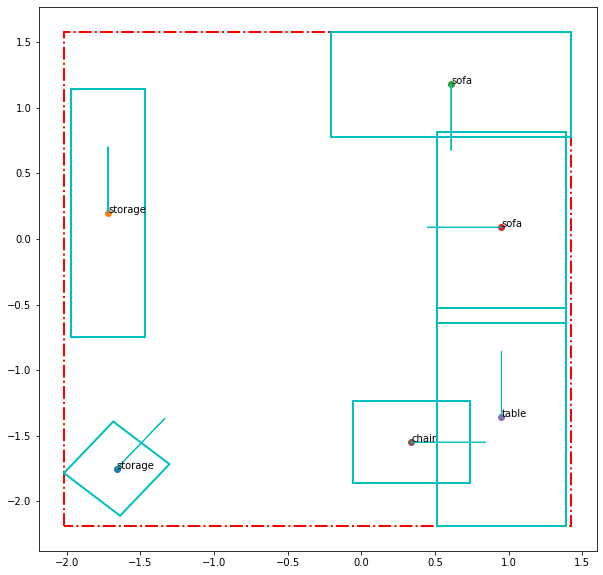

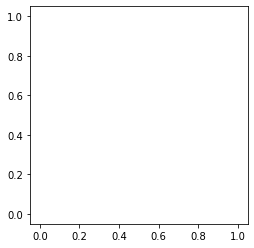

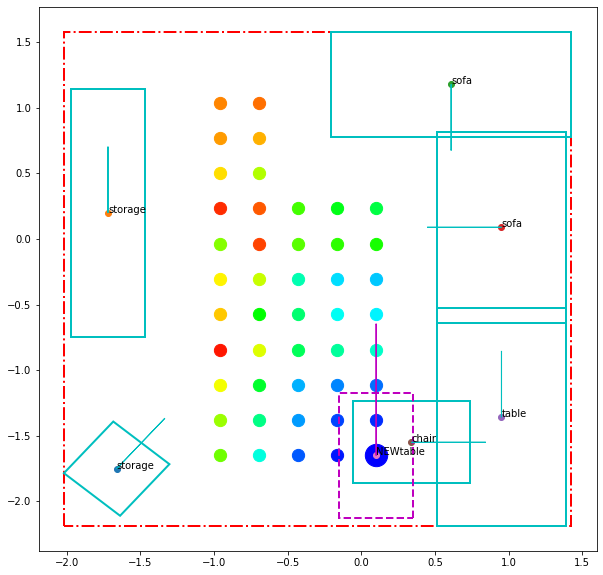

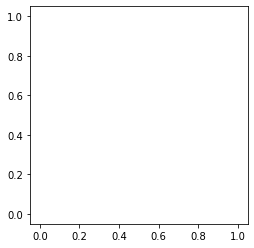

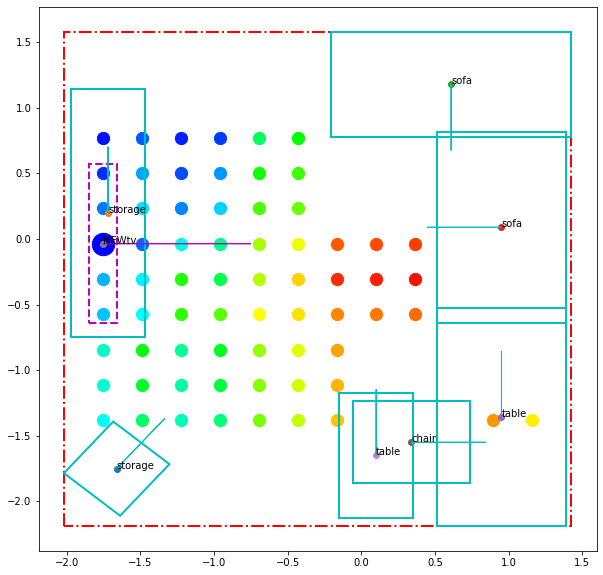

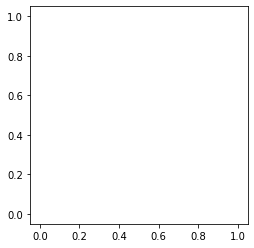

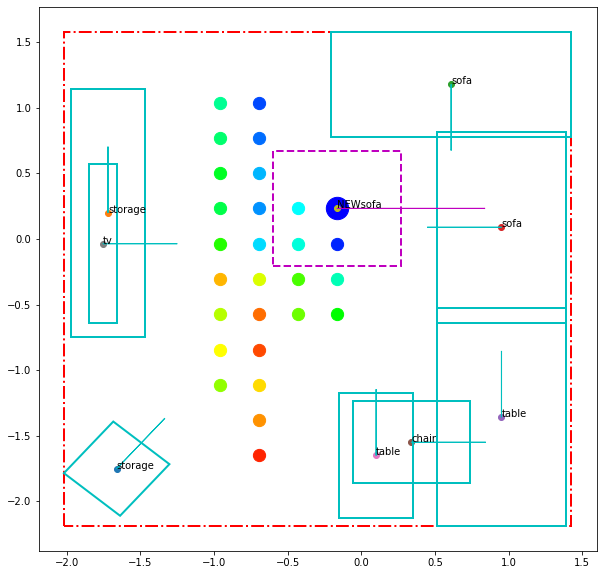

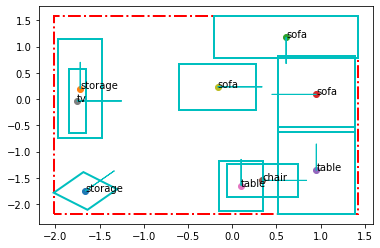

In [19]:
augmentScene(room ='test_livingroom.txt', input_dir = 'input/', output_dir = 'output/multipleobjs/', visualize = True)